<a href="https://colab.research.google.com/github/ishandahal/Sequence-Data-pytorch-/blob/main/Attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Implementing a transformer model

Preparing the Data 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!python -m spacy download de

     |████████████████████████████████| 14.9MB 3.8MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=3f39588fd825c36f53176e913d8b1f2dfa31f450b4659dab461140d87f8a3c62
  Stored in directory: /tmp/pip-ephem-wheel-cache-ds4crps_/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [4]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 810kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 248kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 237kB/s]


In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

Building the model

Encoder

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
        super(Encoder, self).__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        # src : [batch size, src len]
        # src_mask : [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos : [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src : [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        # src : [batch size, src len, hid dim]

        return src

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # src : [batch size, src len, hid dim]
        # src_mask : [batch size, 1, 1, src len]

        # self attention 
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src : [batch size, src len, hid dim]

        # positionwise feedforward 
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src : [batch size, src len, hid dim]

        return src

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super(MultiHeadAttentionLayer, self).__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):

        batch_size = query.shape[0]

        # query : [batch size, query len, hid dim]
        # key : [batch size, query len, hid dim]
        # value : [batch size, query len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q : [batch size, query len, hid dim]
        # K : [batch size, key len, hid dim]
        # V : [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q : [batch_size, n heads, query len, head dim]
        # K : [batch_size, n heads, key len, head dim]
        # V : [batch_size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy : [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)

        # attention : [batch size, n heads, query len, key len] 

        x = torch.matmul(self.dropout(attention), V)

        # x : [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x : [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        # x : [batch size, query len, hid dim]

        x = self.fc_o(x)

        # x : [batch size, query len, hid dim]

        return x, attention 

Point-wise Feedforward Layer

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super(PositionwiseFeedforwardLayer, self).__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # x : [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x : [batch size, seq len, pf_dim]

        x = self.fc_2(x)

        # x : [batch size, seq len, hid dim]

        return x

Decoder

In [15]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=100):
        super(Decoder, self).__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                    for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg : [batch size, trg len]
        # enc_src : [batch size, src len, hid dim]
        # trg_mask : [batch size, 1, trg len, trg len]
        # src_mask : [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos : [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg : [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg : [batch size, trg len, hid dim]
        # attention : [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        # output : [batch size, trg len, output dim]

        return output, attention

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super(DecoderLayer, self).__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg : [batch size, trg len, hid dim]
        # enc_src : [batch size, src len, hid dim]
        # trg_mask : [batch size, 1, trg len, trg len]
        # src_mask : [batch size, 1, 1, src len]

        # self.attention
        _trg, _ =  self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm 
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg : [batch size, trg len, hid dim]

        # encoder attention 
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg : [batch size, trg len, hid dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm

        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg : [batch size, trg len, hid dim]
        # attention : [batch size, n heads, trg len, src len]

        return trg, attention

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        # src : [batch size, sic len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask : [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        # trg : [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask : [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        # trg_sub_mask : [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask : [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        # src : [batch size, src len]
        # trg : [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask : [batch size, 1, 1, src len]
        # trg_mask : [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        # enc_src : [batch size, trg len, output dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output : [batch size, trg len, output dim]
        # attention : [batch size, n heads, trg len, src len]

        return output, attention

### Training the model

In [30]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [31]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


In [33]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights);

In [34]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [35]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [36]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 16s
	Train Loss: 4.254 | Train PPL:  70.368
	 Val. Loss: 3.042 |  Val. PPL:  20.938
Epoch: 02 | Time: 0m 16s
	Train Loss: 2.827 | Train PPL:  16.887
	 Val. Loss: 2.324 |  Val. PPL:  10.220
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.244 | Train PPL:   9.436
	 Val. Loss: 1.977 |  Val. PPL:   7.221
Epoch: 04 | Time: 0m 16s
	Train Loss: 1.887 | Train PPL:   6.598
	 Val. Loss: 1.808 |  Val. PPL:   6.097
Epoch: 05 | Time: 0m 16s
	Train Loss: 1.637 | Train PPL:   5.138
	 Val. Loss: 1.711 |  Val. PPL:   5.537
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.448 | Train PPL:   4.256
	 Val. Loss: 1.659 |  Val. PPL:   5.256
Epoch: 07 | Time: 0m 16s
	Train Loss: 1.298 | Train PPL:   3.660
	 Val. Loss: 1.633 |  Val. PPL:   5.121
Epoch: 08 | Time: 0m 16s
	Train Loss: 1.170 | Train PPL:   3.221
	 Val. Loss: 1.626 |  Val. PPL:   5.081
Epoch: 09 | Time: 0m 16s
	Train Loss: 1.063 | Train PPL:   2.896
	 Val. Loss: 1.629 |  Val. PPL:   5.101
Epoch: 10 | Time: 0m 16s
	Train Loss: 0.969 | Train PPL

In [41]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.669 | Test PPL:   5.308 |


Inference

In [42]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [43]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [47]:
example_idx = 18

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['fünf', 'personen', 'sitzen', 'mit', 'instrumenten', 'im', 'kreis', '.']
trg = ['five', 'people', 'are', 'sitting', 'in', 'a', 'circle', 'with', 'instruments', '.']


In [48]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['five', 'people', 'are', 'sitting', 'in', 'a', 'circle', 'with', 'instruments', '.', '<eos>']


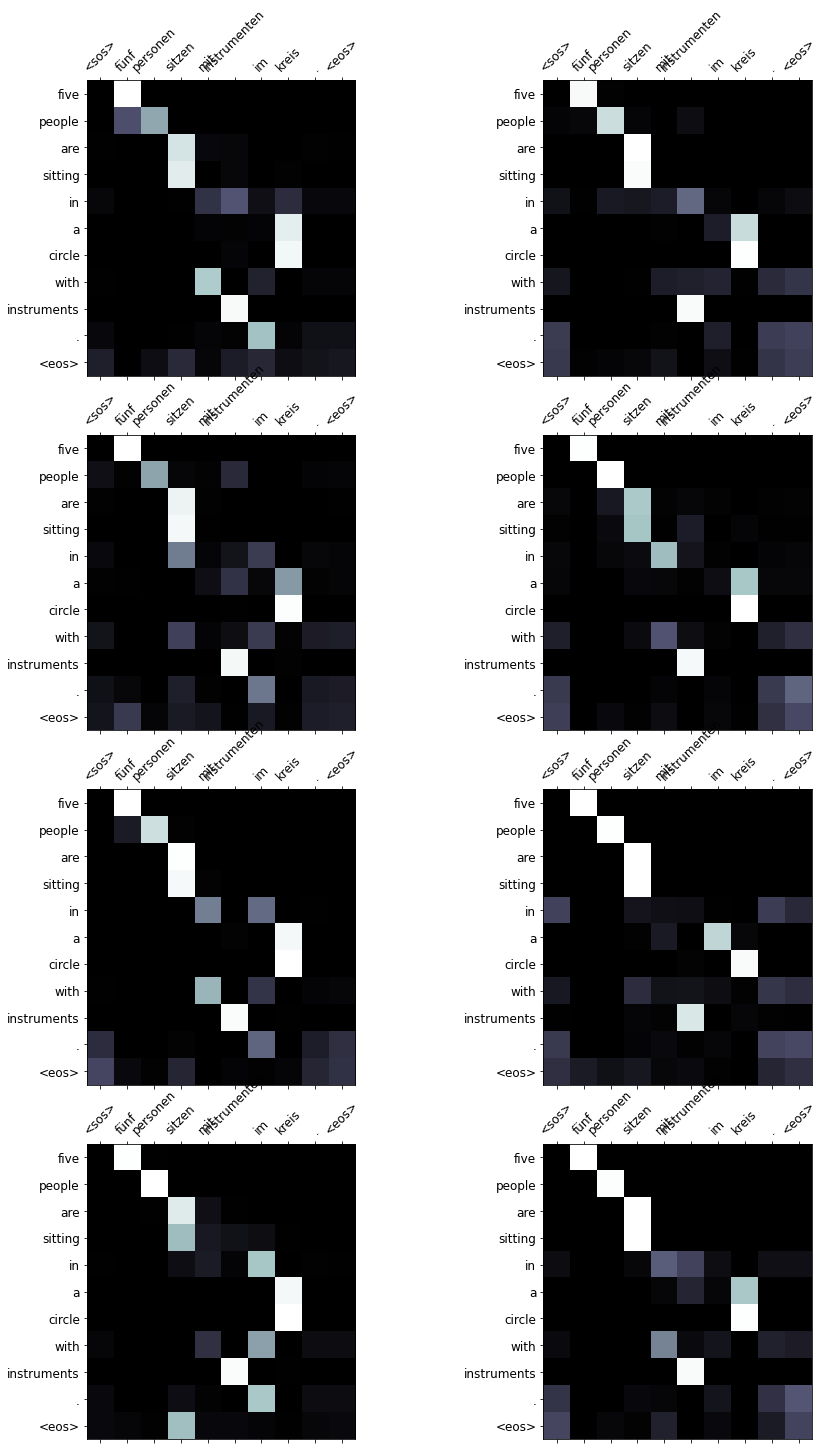

In [49]:
display_attention(src, translation, attention)

Example from validation set

In [50]:
example_idx = 34

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'gruppe', 'von', 'menschen', 'sammelt', 'sich', 'um', 'einen', 'mann', 'in', 'einem', 'anzug', 'und', 'einen', 'kleinen', 'jungen', '.']
trg = ['a', 'group', 'of', 'people', 'collect', 'around', 'a', 'man', 'in', 'a', 'suit', 'and', 'a', 'little', 'boy', '.']


In [51]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'group', 'of', 'people', 'gather', 'around', 'a', 'man', 'in', 'a', 'suit', 'and', 'a', 'little', 'boy', 'in', 'a', 'suit', '.', '<eos>']


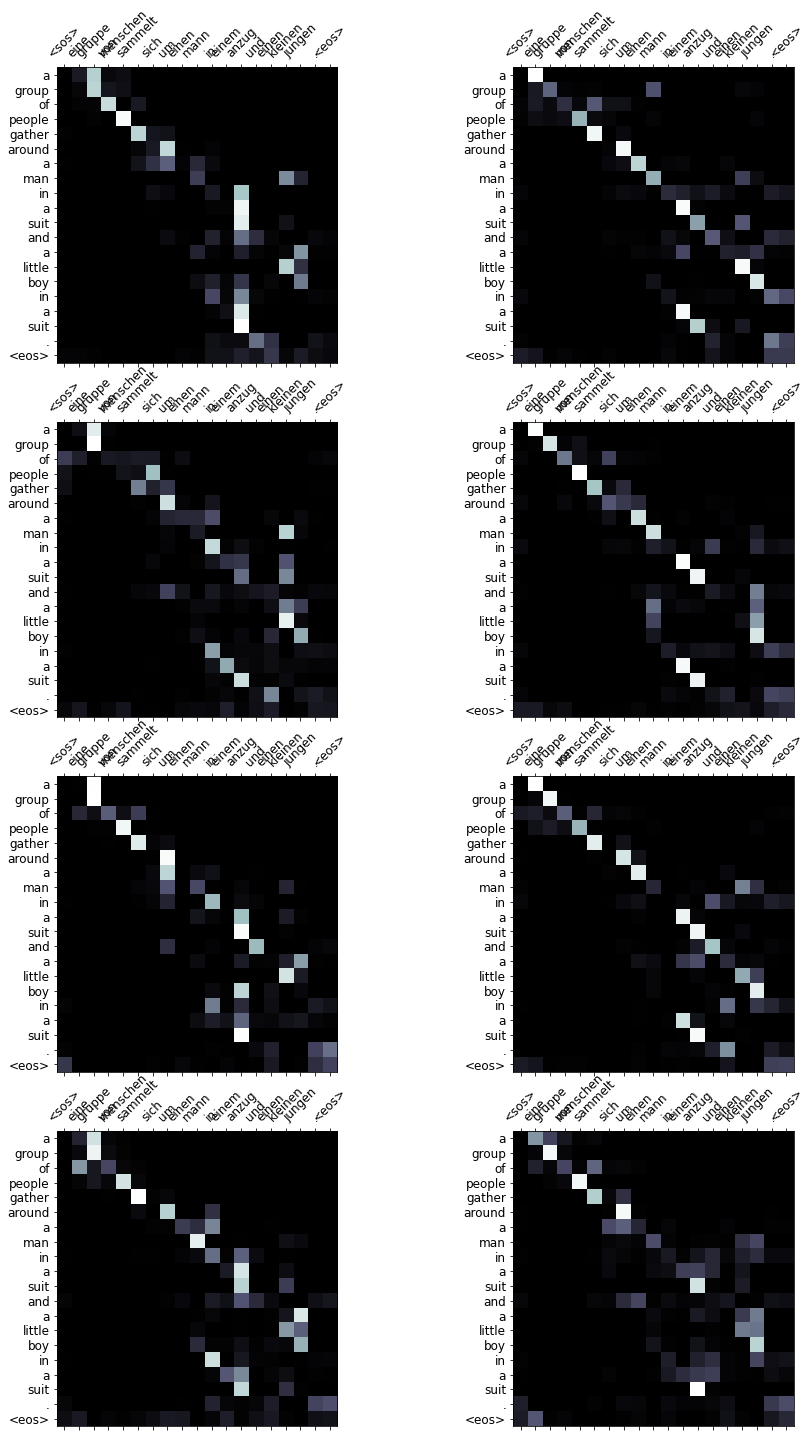

In [52]:
display_attention(src, translation, attention)

Test set

In [55]:
example_idx = 1

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'boston', 'terrier', 'läuft', 'über', 'saftig-grünes', 'gras', 'vor', 'einem', 'weißen', 'zaun', '.']
trg = ['a', 'boston', 'terrier', 'is', 'running', 'on', 'lush', 'green', 'grass', 'in', 'front', 'of', 'a', 'white', 'fence', '.']


In [56]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boston', '<unk>', 'runs', 'across', 'grass', 'in', 'front', 'of', 'a', 'white', 'fence', '.', '<eos>']


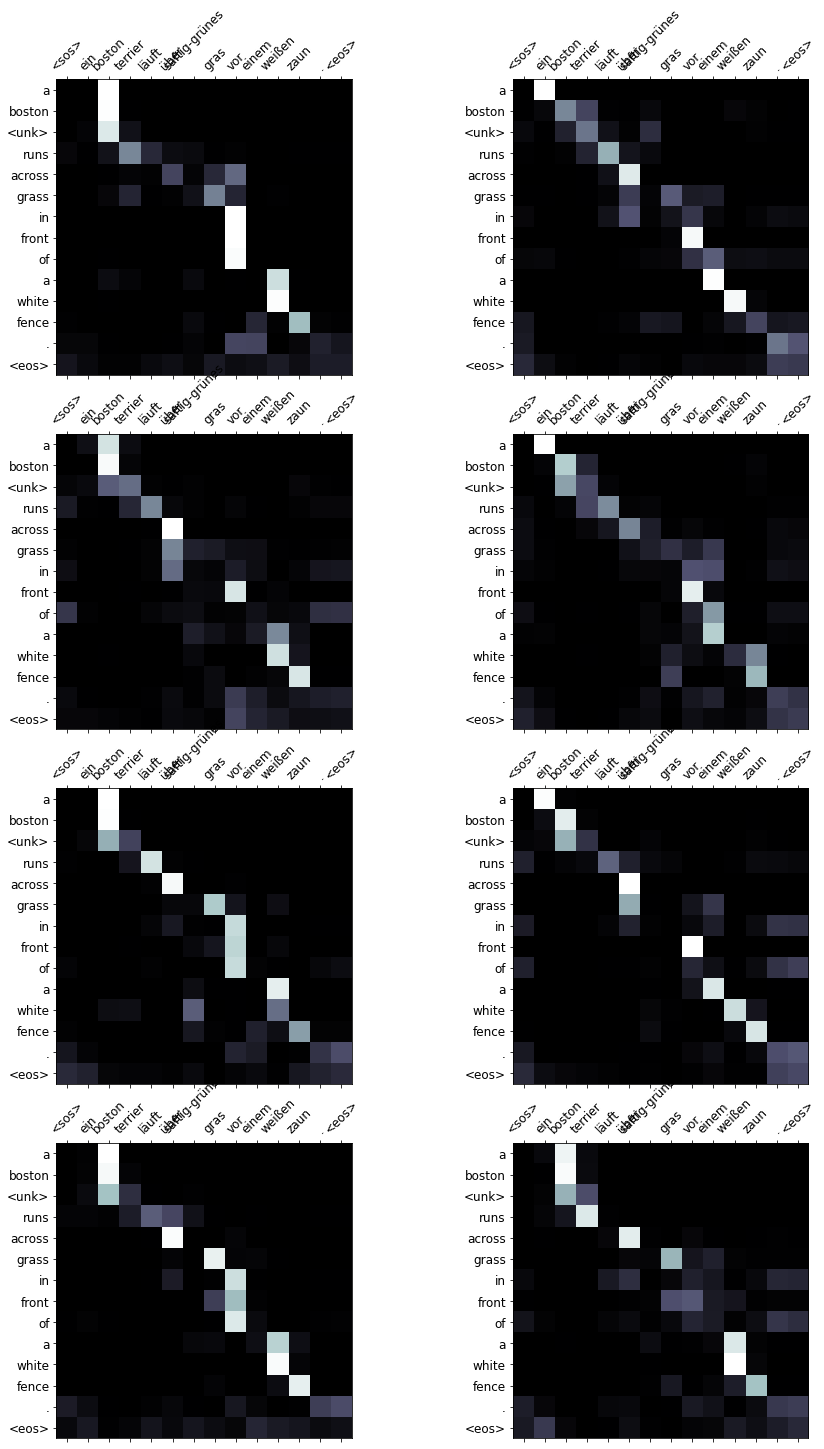

In [57]:
display_attention(src, translation, attention)